In [14]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from pyprojroot import here  # nicked from Simon, cheers man!
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import variation
import scipy.stats as stats

plt.style.use("seaborn")
plt.style.use("seaborn-poster")

# Custom module imports
from src import df_cleaner
from src import plot_functions as pf
from src import plots

sys.path.append(
    str(here())
)  # adds the project directory to a list of locations the python interpreter searches through when attempting to import modules

raw_data_path = here() / "data" / "abalone.csv"

In [16]:
df = pd.read_csv(raw_data_path)
df = df_cleaner.snake_case(df)
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Investigating distributions of each feature

In [17]:
features = df.columns
target = "rings"
features = features.drop(target)

## 1. Sex

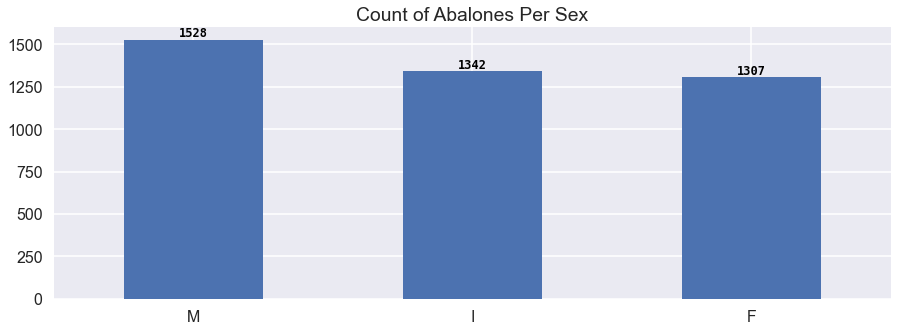

In [18]:
fig = plt.figure(figsize=[15, 5])
ax = plt.axes()
df["sex"].value_counts().plot.bar()
pf.show_values_on_bars(ax)
plt.xticks(rotation=0)
plt.title("Count of Abalones Per Sex")
pf.save_figure(file_name="Count Per Sex", subfolder_name="01.1 Basic EDA")

### Does sex of "I" mean Infant?

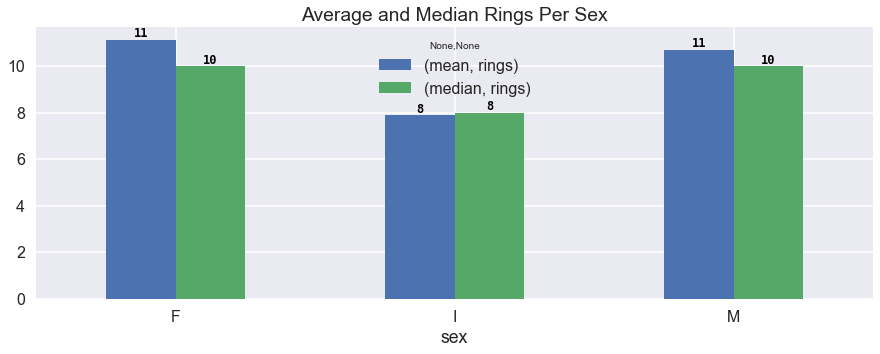

In [19]:
fig = plt.figure(figsize=[15, 5])
ax = plt.axes()
pd.pivot_table(
    data=df[["sex", "rings"]], index="sex", aggfunc=["mean", "median"]
).plot.bar(ax=ax)

pf.show_values_on_bars(ax)
plt.xticks(rotation=0)
plt.title("Average and Median Rings Per Sex")
pf.save_figure(
    file_name="Mean and Median Rings Per Sex", subfolder_name="01.1 Basic EDA"
)

# Plotting the distribution of all numeric columns

In [20]:
numeric_columns = df.select_dtypes(include="number").columns

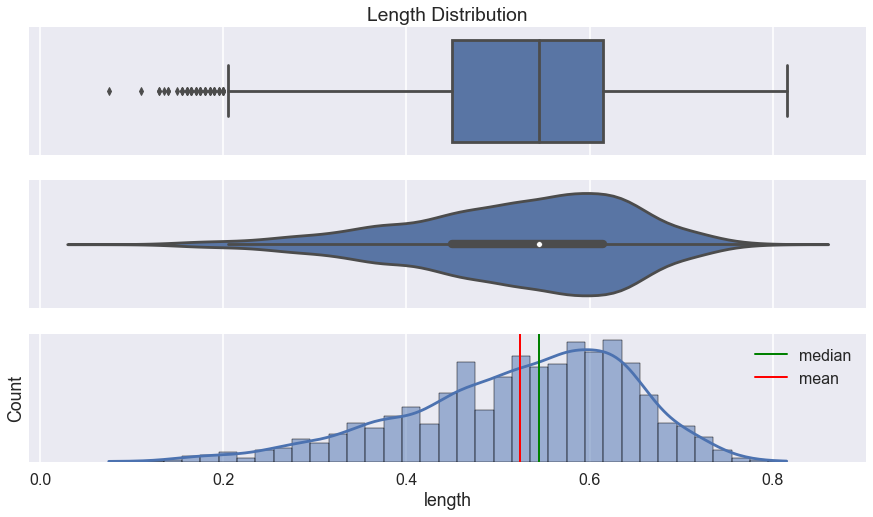

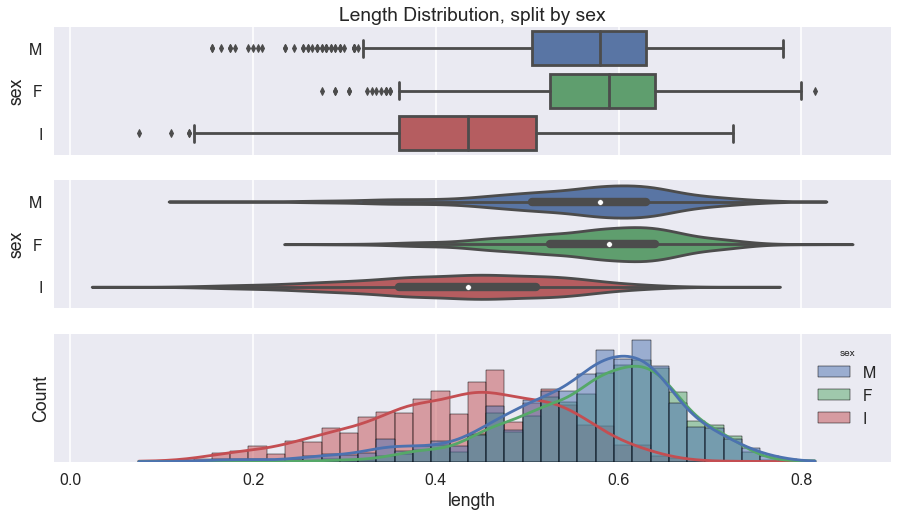

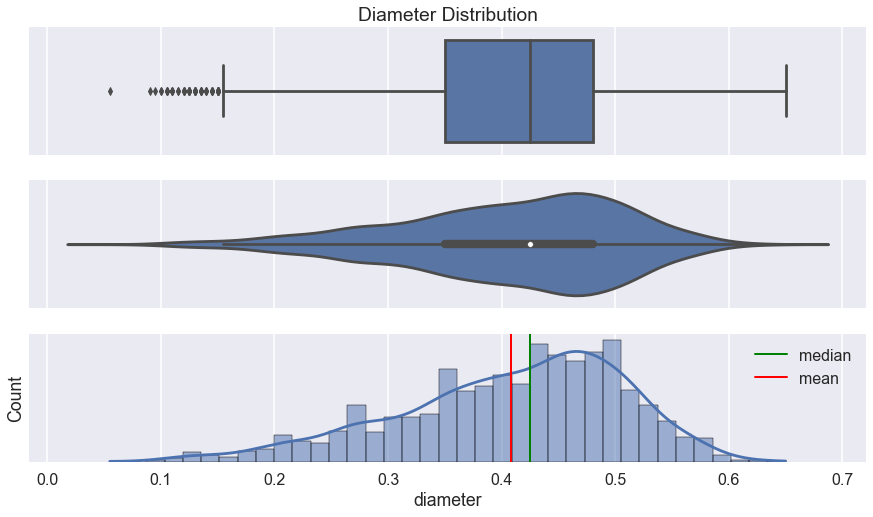

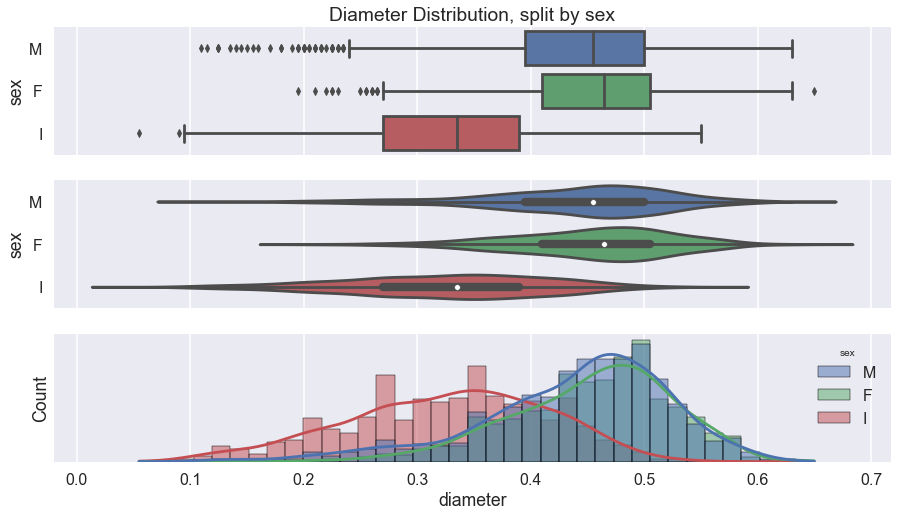

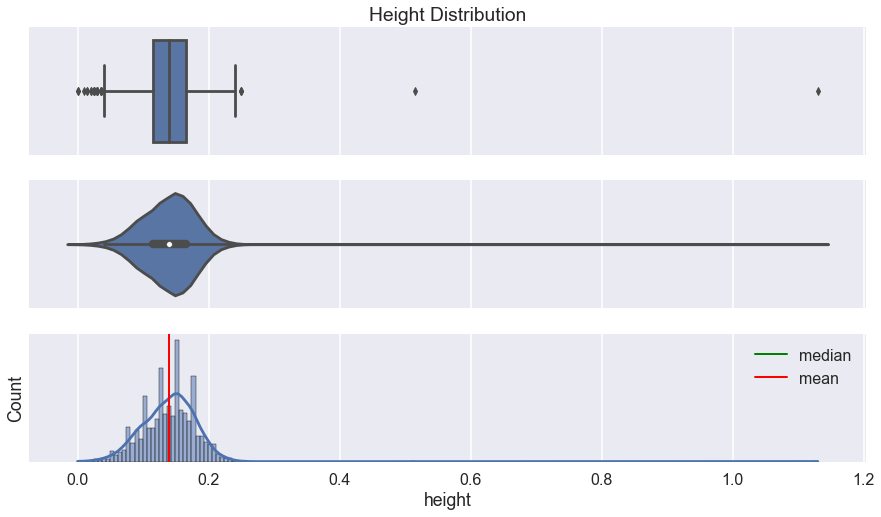

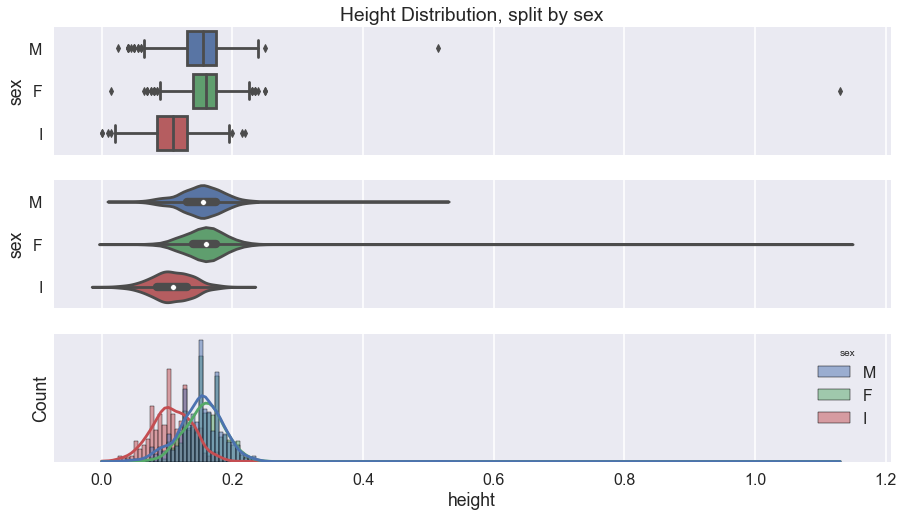

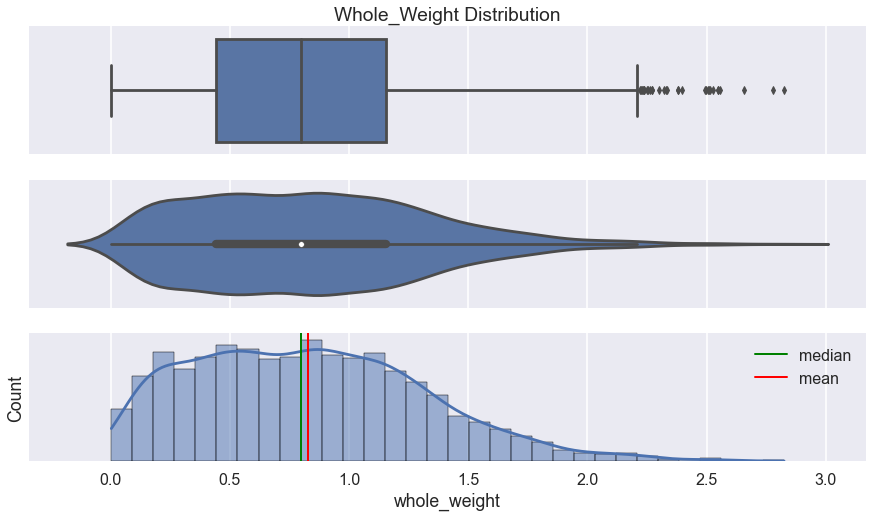

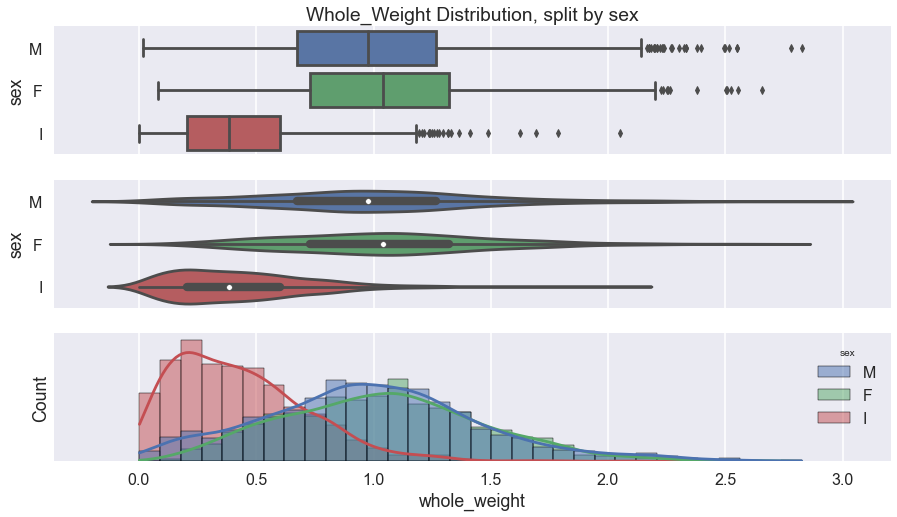

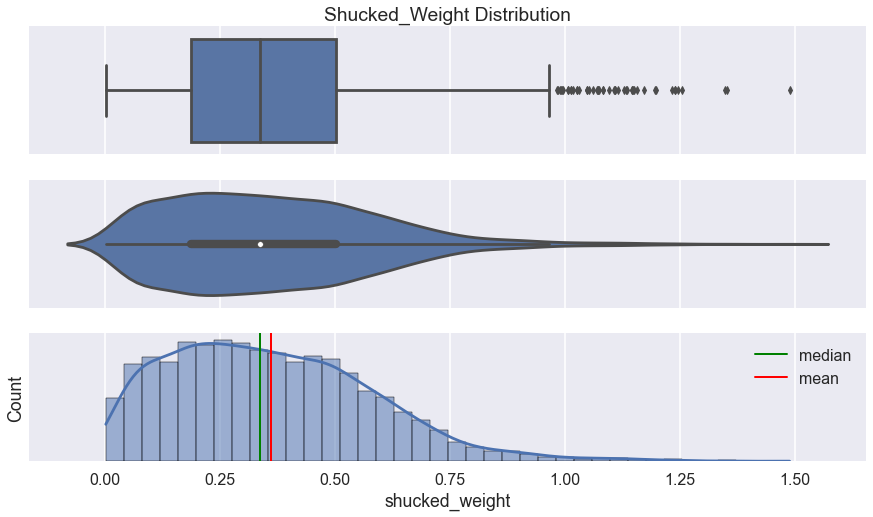

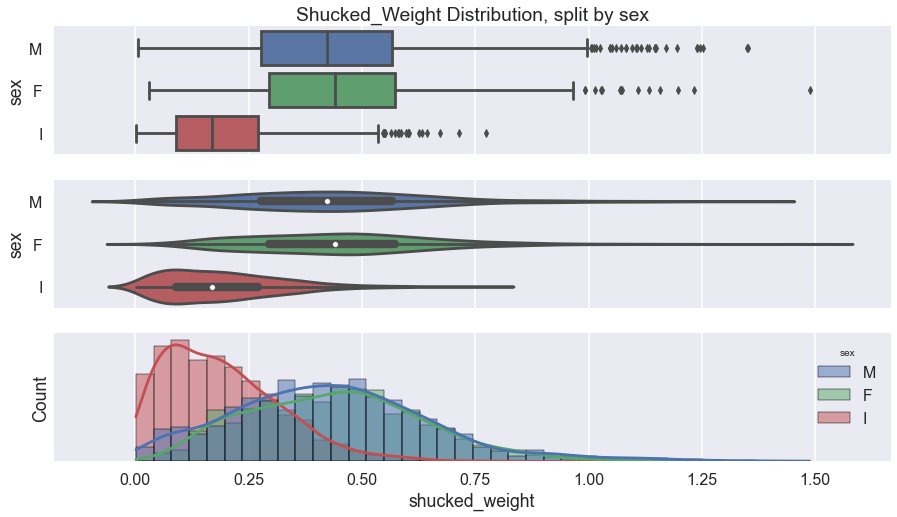

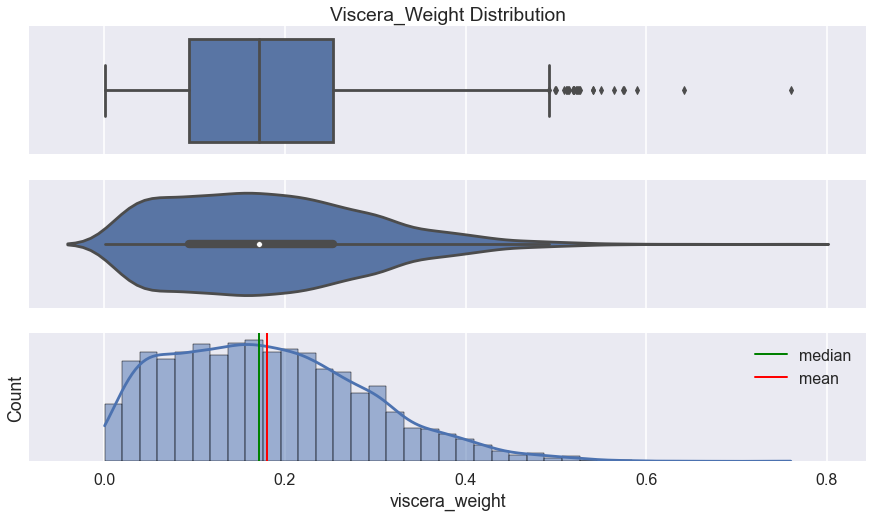

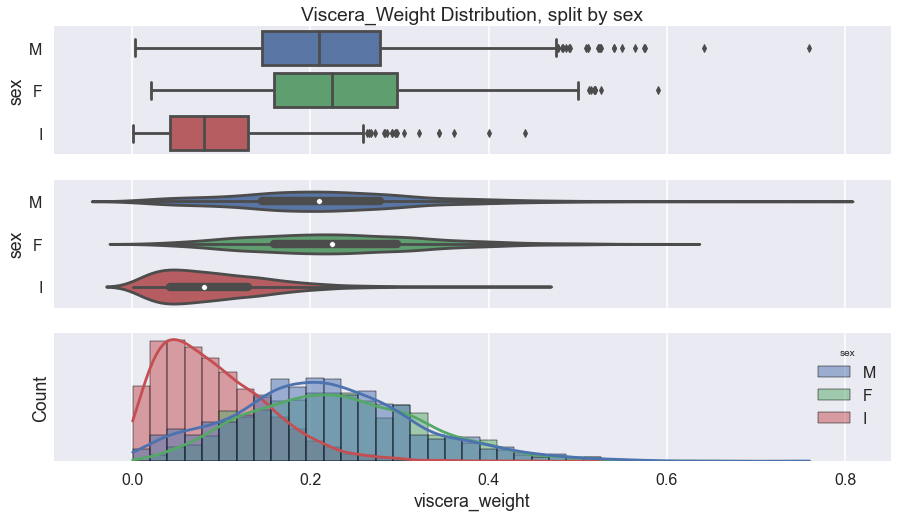

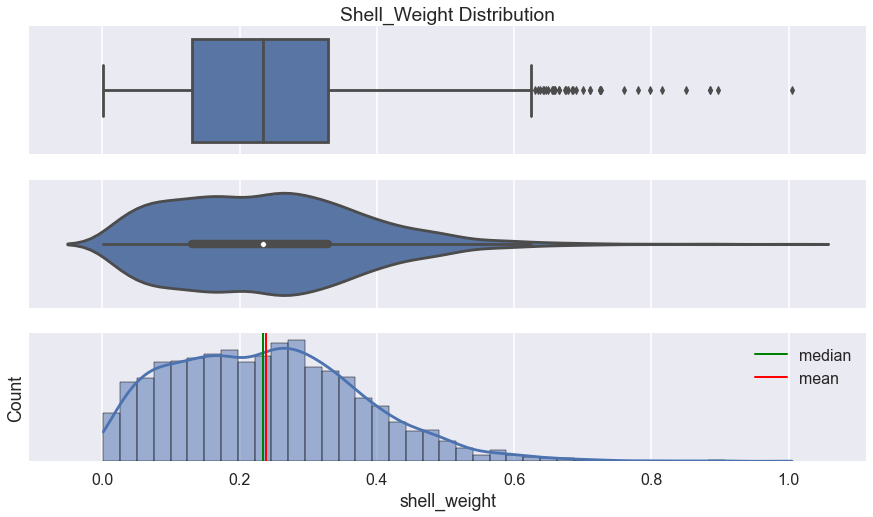

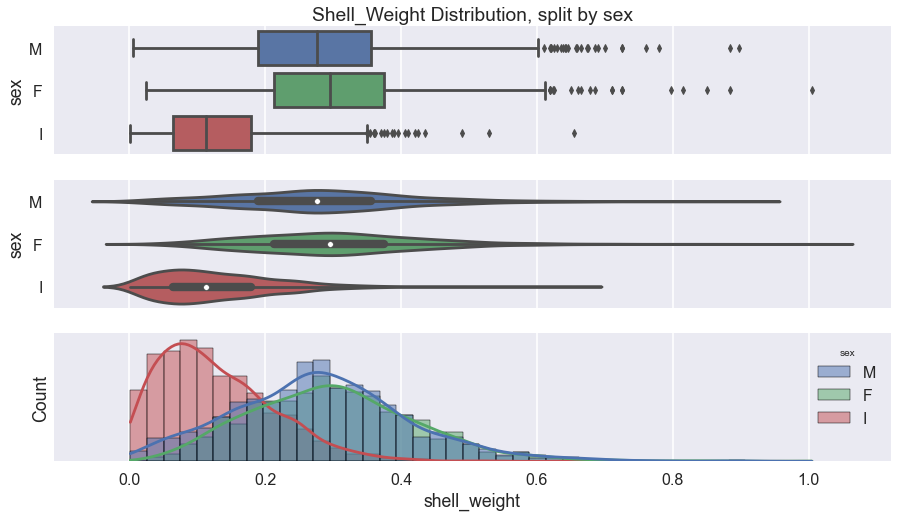

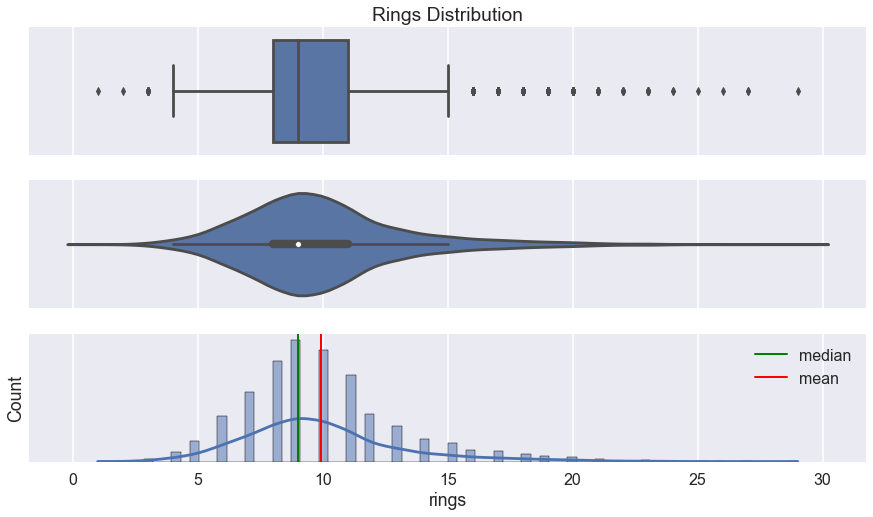

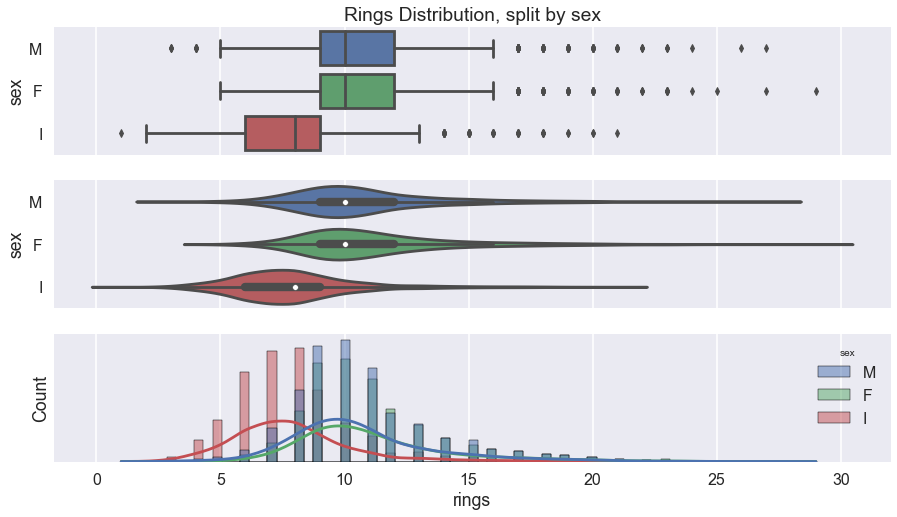

In [21]:
import warnings

warnings.filterwarnings("ignore")

for col in numeric_columns:
    plots.distribution_plot(df, col)
    plots.distribution_plot(df, col, hue="sex")
    print("")

# Plotting descriptive statistics for histograms / features
Will be good to programmatically get these key metrics for each column, and can then plot to see which have most skewness, are most and least Gaussian etc

- Central location
- Spread
- Skewness
- Kurtosis
- Coefficient of variance
- Chi square with Normal distribution assumption

### Make empty df with the correct index to join subsequent dfs onto 

In [23]:
df_stats = pd.DataFrame(
    {
        "Statistic": [
            "mean",
            "median",
            "std",
            "skewness",
            "kurtosis",
            "coe_of_v",
        ]
    }
)

df_stats.set_index("Statistic", inplace=True)

### Iterate over numerical columns calculating statistics and joining onto dataframe

In [24]:
for col in numeric_columns:
    # Get statistics
    mean = df[col].mean()
    median = df[col].median()
    sd = df[col].std()
    sk = df[col].skew()
    ku = df[col].kurt()
    cv = variation(df[col])

    # Create a dataframe
    d = {
        "Statistic": [
            "mean",
            "median",
            "std",
            "skewness",
            "kurtosis",
            "coe_of_v",
        ],
        col: [mean, median, sd, sk, ku, cv],
    }

    df_stats_ = pd.DataFrame(d)
    df_stats_.set_index("Statistic", inplace=True)

    # Merge onto original column-less dataframe
    df_stats = df_stats.merge(df_stats_, left_index=True, right_index=True)

In [25]:
df_stats

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
Statistic,,,,,,,,
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
median,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
skewness,-0.639873,-0.609198,3.128817,0.530959,0.719098,0.591852,0.620927,1.114102
kurtosis,0.064621,-0.045476,76.025509,-0.023644,0.595124,0.084012,0.531926,2.330687
coe_of_v,0.229161,0.243277,0.299764,0.591656,0.617575,0.606894,0.582781,0.324530


<AxesSubplot:xlabel='Statistic'>

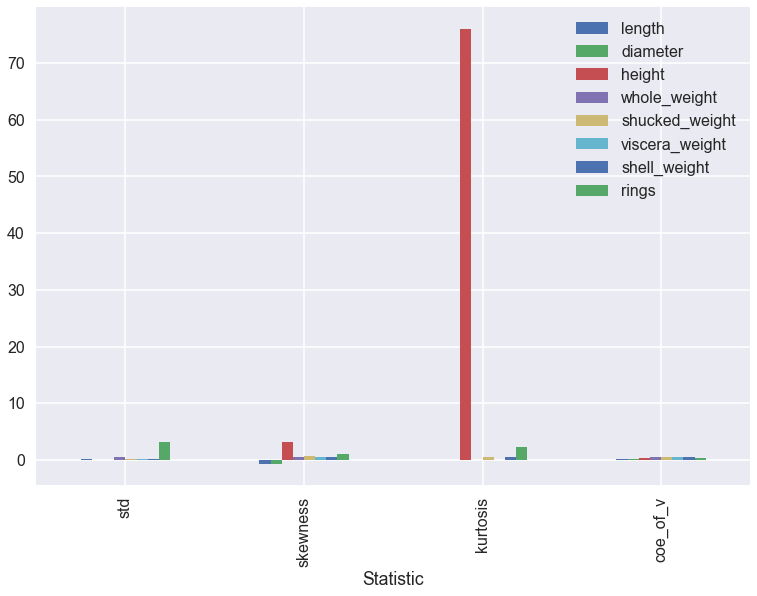

In [26]:
df_stats.loc[["std", "skewness", "kurtosis", "coe_of_v"]].plot.bar()

## Conclusions re: data distribution
- Rings has highest standard deviation
- Height had highest skewness
- Height has **very** high kurtosis
- None have significant coefficient of variation, although could be due to height kurtosis dwarfing the rest

## Replacing height kurtosis with 10, just to get a more zoomed in look at the rest

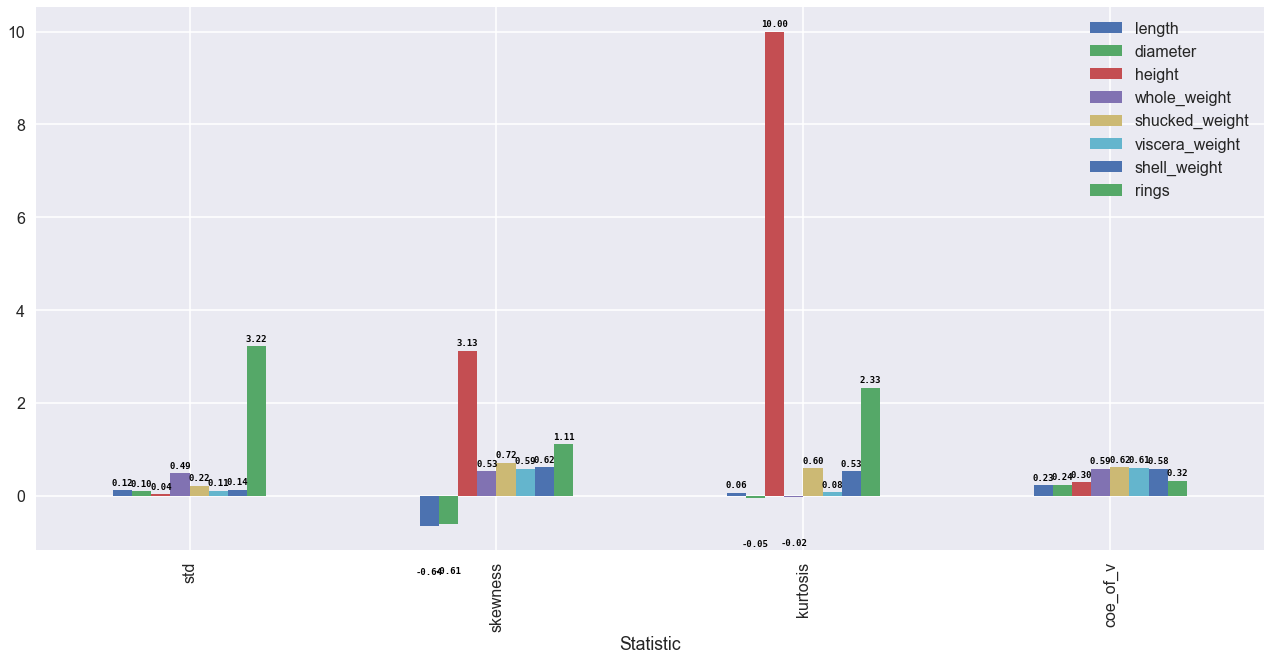

In [36]:
fig = plt.figure(figsize=[22, 10])
ax = plt.axes()

df_stats.loc[["std", "skewness", "kurtosis", "coe_of_v"]].replace(
    df_stats.loc["kurtosis"]["height"], 10
).plot.bar(ax=ax)

pf.show_values_on_bars(ax, round_annot=False, fontsize=9)

## Questions to investigate:
- What does a skewness of 1 mean? Of 3?
- Kurtosis - "extreme" tails vs spare tails?

---

# Goodness of Fit: are the features normally distributed?
Following code from [here](https://analyticsindiamag.com/goodness-of-fit-python-guide/), this is far beyond my knowledge which means I may have made mistakes

## First trying with a single feature, length:

In [37]:
# Binning the data: creating the bin intervals
mean = np.mean(df["length"])
std = np.std(df["length"])
bins = 8
interval = []
for i in range(1, 9):
    val = stats.norm.ppf(i / bins, mean, std)
    interval.append(val)

df_bins = pd.DataFrame({"lower_limit": interval[:-1], "upper_limit": interval[1:]})
df_bins

,lower_limit,upper_limit
0,0.385860,0.443000
1,0.443000,0.485730
2,0.485730,0.523992
3,0.523992,0.562254
4,0.562254,0.604984
5,0.604984,0.662124
6,0.662124,inf


In [38]:
# Calculating frequency of data in the bins
values = list(sorted(df["length"]))
df_bins["obs_freq"] = df_bins.apply(
    lambda x: sum([i > x["lower_limit"] and i <= x["upper_limit"] for i in values]),
    axis=1,
)
df_bins["exp_freq"] = len(values) / 8
df_bins

,lower_limit,upper_limit,obs_freq,exp_freq
0,0.385860,0.443000,360,522.125
1,0.443000,0.485730,445,522.125
2,0.485730,0.523992,405,522.125
3,0.523992,0.562254,516,522.125
4,0.562254,0.604984,617,522.125
5,0.604984,0.662124,830,522.125
6,0.662124,inf,386,522.125


We are now ready to perform the Goodness-of-Fit test. We can state our null hypothesis at a 5% level of significance as:

"The bulb follows normal distribution"

Calculate the actual Chi-Square value using the chisquare method available in SciPy’s stats module.



In [39]:
chi_square_val = stats.chisquare(df_bins["obs_freq"], df_bins["exp_freq"])
chi_square_val = chi_square_val.statistic

Calculate the critical Chi-Square value using the chi2.ppf method available in SciPy’s stats module.


In [40]:
p = 2  # number of parameters
DOF = len(df_bins["obs_freq"]) - p - 1
crit_chi_square_val = stats.chi2.ppf(0.95, DOF)

It is observed that the calculated Chi-Square value 6.4 is less than the critical value 11.07. Hence, the null hypothesis can not be rejected. In other words, the life of bulbs are normally distributed.

If chi-square value is less than critical value, null can't be rejected, and the distribution is normal
- If chi-square < critical, normal distribution
- If chi-square > critical, non-normal

In [41]:
if chi_square_val < crit_chi_square_val:
    print("Normal distribution")
else:
    print("Non-normal distribution")

Non-normal distribution


# Now iterating over all

In [43]:
# Binning the data: creating the bin intervals
for col in numeric_columns:
    mean = np.mean(df[col])
    std = np.std(df[col])
    bins = 8
    interval = []
    for i in range(1, 9):
        val = stats.norm.ppf(i / bins, mean, std)
        interval.append(val)

    df_bins = pd.DataFrame({"lower_limit": interval[:-1], "upper_limit": interval[1:]})

    # Calculating frequency of data in the bins
    values = list(sorted(df[col]))
    df_bins["obs_freq"] = df_bins.apply(
        lambda x: sum([i > x["lower_limit"] and i <= x["upper_limit"] for i in values]),
        axis=1,
    )
    df_bins["exp_freq"] = len(values) / 8
    df_bins

    chi_square_val = stats.chisquare(df_bins["obs_freq"], df_bins["exp_freq"])
    chi_square_val = chi_square_val.statistic

    p = 2  # number of parameters
    DOF = len(df_bins["obs_freq"]) - p - 1
    crit_chi_square_val = stats.chi2.ppf(0.95, DOF)

    if chi_square_val < crit_chi_square_val:
        print(f"{col} has Normal distribution")
    else:
        print(f"{col} has Non-normal distribution")

length has Non-normal distribution
diameter has Non-normal distribution
height has Non-normal distribution
whole_weight has Non-normal distribution
shucked_weight has Non-normal distribution
viscera_weight has Non-normal distribution
shell_weight has Non-normal distribution
rings has Non-normal distribution
